# Flight delay prediction

Import the needed libraries

In [12]:
import pandas as pd
import seaborn as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


From a technical point of view, the main aspects of python covered throughout the notebook are:

visualization: matplolib, seaborn, basemap
data manipulation: pandas, numpy
modeling: sklearn, scipy
class definition: regression, figures

Read the data set // Make sure you have dataset and ipynb file in same folder

In [13]:
data=pd.read_csv('flights.csv',low_memory=False)

Displaying some rows of datasets

In [14]:
data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data_extract=data.head(100000)

TO fetch 100000 rows of dataset

In [16]:
data_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 100000 non-null  int64  
 1   MONTH                100000 non-null  int64  
 2   DAY                  100000 non-null  int64  
 3   DAY_OF_WEEK          100000 non-null  int64  
 4   AIRLINE              100000 non-null  object 
 5   FLIGHT_NUMBER        100000 non-null  int64  
 6   TAIL_NUMBER          99833 non-null   object 
 7   ORIGIN_AIRPORT       100000 non-null  object 
 8   DESTINATION_AIRPORT  100000 non-null  object 
 9   SCHEDULED_DEPARTURE  100000 non-null  int64  
 10  DEPARTURE_TIME       97702 non-null   float64
 11  DEPARTURE_DELAY      97702 non-null   float64
 12  TAXI_OUT             97629 non-null   float64
 13  WHEELS_OFF           97629 non-null   float64
 14  SCHEDULED_TIME       100000 non-null  int64  
 15  ELAPSED_TIME      

In [17]:
data.shape

(248437, 31)

In [18]:
data_extract['DIVERTED'].value_counts()

DIVERTED
0.0    99776
1.0      224
Name: count, dtype: int64

In [19]:
# Display correlations for numeric columns only
numeric_cols = data_extract.select_dtypes(include=['float64', 'int64']).columns
data_extract[numeric_cols].corr()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAY,NaN,NaN,1.000000,-0.497084,0.004412,-0.138130,-0.124369,0.060064,0.093451,-0.119781,...,0.037407,-0.110820,-0.091687,0.004847,-0.006000,0.097693,-0.010550,-0.001603,0.033213,0.061960
DAY_OF_WEEK,NaN,NaN,-0.497084,1.000000,0.010955,0.046914,0.045182,0.055632,0.007291,0.044150,...,-0.017789,0.031725,0.011477,-0.000709,-0.006409,-0.019626,0.008156,0.003648,0.033729,-0.050835
FLIGHT_NUMBER,NaN,NaN,0.004412,0.010955,1.000000,-0.003027,0.010140,0.034863,0.061010,0.016377,...,0.014464,-0.018891,0.000753,0.007155,0.090008,-0.032564,-0.007260,0.023770,0.076581,0.004246
SCHEDULED_DEPARTURE,NaN,NaN,-0.138130,0.046914,-0.003027,1.000000,0.943186,0.174254,-0.081496,0.912232,...,-0.027502,0.731240,0.552653,0.002515,-0.002631,-0.112393,-0.017957,-0.054419,0.186286,-0.042004
DEPARTURE_TIME,NaN,NaN,-0.124369,0.045182,0.010140,0.943186,1.000000,0.243960,-0.070081,0.966477,...,-0.017759,0.734970,0.584615,0.006576,0.009679,-0.093096,-0.012820,-0.013304,0.247325,-0.046406
DEPARTURE_DELAY,NaN,NaN,0.060064,0.055632,0.034863,0.174254,0.243960,1.000000,0.061905,0.231399,...,0.040285,0.155150,0.079639,0.020787,0.030862,0.085794,0.008040,0.606954,0.605289,0.210402
TAXI_OUT,NaN,NaN,0.093451,0.007291,0.061010,-0.081496,-0.070081,0.061905,1.000000,-0.043114,...,0.009041,-0.062325,-0.045611,0.009810,0.010763,0.407371,-0.008021,-0.024674,-0.129879,0.119412
WHEELS_OFF,NaN,NaN,-0.119781,0.044150,0.016377,0.912232,0.966477,0.231399,-0.043114,1.000000,...,-0.015089,0.744697,0.608611,0.006524,0.001293,-0.085582,-0.013912,-0.017376,0.223010,-0.055273


In [20]:
data_extract.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

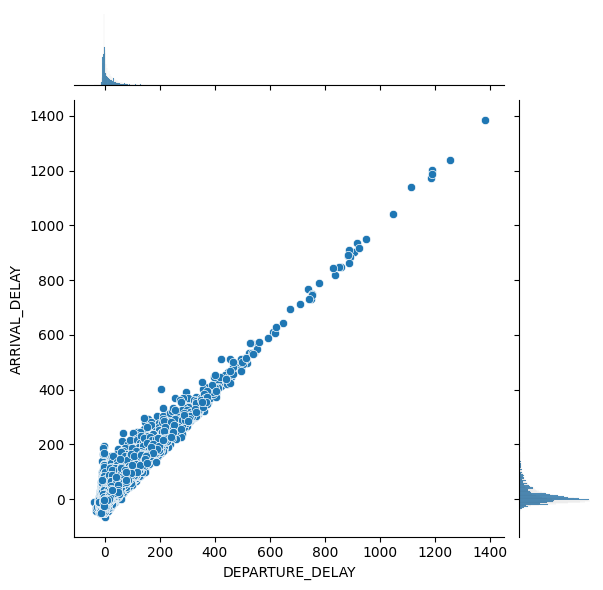

In [11]:
sm.jointplot(x=data_extract['DEPARTURE_DELAY'],y=data_extract['ARRIVAL_DELAY'],sizes=(10,12))

In [21]:
info=data_extract[['MONTH', 'DAY','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','DEPARTURE_DELAY','SCHEDULED_ARRIVAL',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']]

In [22]:
info.head()

,MONTH,DAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1,1,ANC,SEA,5,-11.0,430,-22,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,1,LAX,PBI,10,-8.0,750,-9,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1,1,SFO,CLT,20,-2.0,806,5,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1,1,LAX,MIA,20,-5.0,805,-9,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1,1,SEA,ANC,25,-1.0,320,-21,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [24]:
# Filter numeric columns for correlation matrix
numeric_info = info.select_dtypes(include=['float64', 'int64'])
print(numeric_info.corr())

# Fill missing values with the mean of each numeric column
info = info.apply(pd.to_numeric, errors='coerce')
info = info.fillna(info.mean())

# Create a target variable 'Result'
info['Result'] = (info['ARRIVAL_DELAY'] > 15).astype(int)

# Display value counts for the target variable
print(info['Result'].value_counts())

                     MONTH       DAY  SCHEDULED_DEPARTURE  DEPARTURE_DELAY  \
MONTH                  NaN       NaN                  NaN              NaN   
DAY                    NaN  1.000000            -0.138130         0.060064   
SCHEDULED_DEPARTURE    NaN -0.138130             1.000000         0.174254   
DEPARTURE_DELAY        NaN  0.060064             0.174254         1.000000   
SCHEDULED_ARRIVAL      NaN -0.110820             0.731240         0.155150   
DIVERTED               NaN  0.004847             0.002515         0.020787   
CANCELLED              NaN -0.006000            -0.002631         0.030862   
AIR_SYSTEM_DELAY       NaN  0.097693            -0.112393         0.085794   
SECURITY_DELAY         NaN -0.010550            -0.017957         0.008040   
AIRLINE_DELAY          NaN -0.001603            -0.054419         0.606954   
LATE_AIRCRAFT_DELAY    NaN  0.033213             0.186286         0.605289   
WEATHER_DELAY          NaN  0.061960            -0.042004       

In [26]:
info['Result'].value_counts()

Result
0    63779
1    36221
Name: count, dtype: int64

In [25]:
info.columns

Index(['MONTH', 'DAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'Result'],
      dtype='object')

In [33]:
X=info[['MONTH', 'DAY','SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY']]

In [35]:
y=info['Result']
X = X[:len(y)]

scaler=StandardScaler()

In [36]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
dt_roc_auc = roc_auc_score(y_test, dt_pred)


In [45]:
# Random Forest Classifier with hyperparameter tuning
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='roc_auc')
rf_grid_search.fit(x_train, y_train)
rf_best_clf = rf_grid_search.best_estimator_
rf_pred = rf_best_clf.predict(x_test)
rf_roc_auc = roc_auc_score(y_test, rf_pred)

In [42]:
# Gradient Boosting Classifier with hyperparameter tuning
gb_clf = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid_search = GridSearchCV(gb_clf, gb_param_grid, cv=5, scoring='roc_auc')
gb_grid_search.fit(x_train, y_train)
gb_best_clf = gb_grid_search.best_estimator_
gb_pred = gb_best_clf.predict(x_test)
gb_roc_auc = roc_auc_score(y_test, gb_pred)


In [43]:
# LSTM Model
lstm_x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
lstm_x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, x_train.shape[1])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

lstm_model.fit(lstm_x_train, y_train, epochs=10, batch_size=64, validation_data=(lstm_x_test, y_test))

lstm_pred_prob = lstm_model.predict(lstm_x_test)
lstm_pred = (lstm_pred_prob > 0.5).astype(int)
lstm_roc_auc = roc_auc_score(y_test, lstm_pred)


Epoch 1/10
1094/1094 [==============================] - 7s 4ms/step - loss: 0.1302 - auc: 0.9944 - val_loss: 0.0345 - val_auc: 0.9989
Epoch 2/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0324 - auc: 0.9989 - val_loss: 0.0278 - val_auc: 0.9994
Epoch 3/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0265 - auc: 0.9994 - val_loss: 0.0221 - val_auc: 0.9996
Epoch 4/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0216 - auc: 0.9997 - val_loss: 0.0180 - val_auc: 0.9998
Epoch 5/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0172 - auc: 0.9998 - val_loss: 0.0143 - val_auc: 0.9999
Epoch 6/10
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0135 - auc: 0.9999 - val_loss: 0.0111 - val_auc: 1.0000
Epoch 7/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0107 - auc: 1.0000 - val_loss: 0.0091 - val_auc: 1.0000
Epoch 8/10
1094/1094 [==============================] - 6s 5ms

In [46]:
# Print ROC AUC scores
print(f"Decision Tree ROC AUC: {dt_roc_auc}")
print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Gradient Boosting ROC AUC: {gb_roc_auc}")
print(f"LSTM ROC AUC: {lstm_roc_auc}")

Decision Tree ROC AUC: 1.0
Random Forest ROC AUC: 1.0
Gradient Boosting ROC AUC: 1.0
LSTM ROC AUC: 0.9999216300940439
